In [314]:
from google.colab import drive
drive.mount('/content/drive')

!git clone https://github.com/HitoshiIyatomi/IIP1.git

!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'IIP1' already exists and is not an empty directory.
Wed May 31 20:36:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |   1147MiB / 15360MiB |      0%      Default |
|                               |         

In [315]:
# import module
import random
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataset import Subset
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision import datasets

from tqdm import tqdm

In [316]:
# init random seeds
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)

In [317]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [318]:
#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.Resize(256), transforms.CenterCrop(224)])
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

#train_len = 30000
#test_len = 10000
#train_dataset = Subset(trainset,[i for i in range(0,train_len)])
#test_dataset = Subset(testset,[i for i in range(0,test_len)])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


plane  frog


torch.Tensor

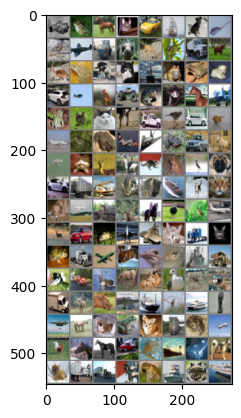

In [319]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(2)))

type(torchvision.utils.make_grid(images))

In [320]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


torch.Size([128, 3, 32, 32])
<class 'torch.Tensor'>


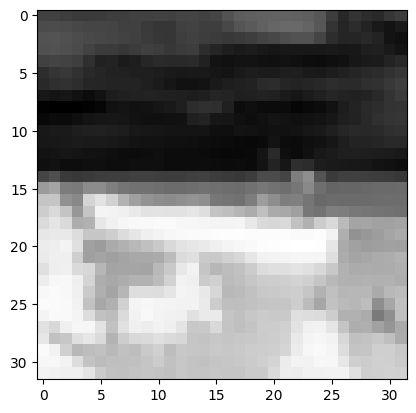

torch.Size([128, 1, 32, 32])


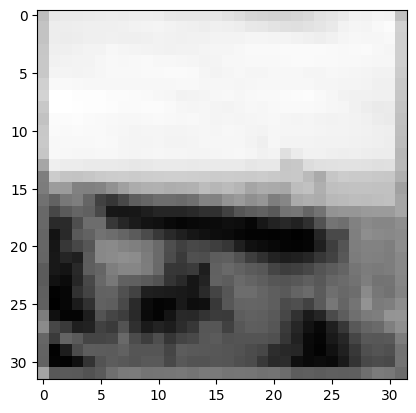

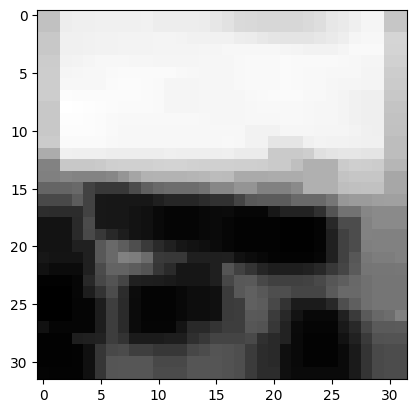

In [321]:
images, labels = next(dataiter)
print(images.size())
print(type(images))
image_plot = images[0][1].numpy()
plt.imshow(image_plot, cmap='Greys', interpolation='nearest')
plt.show()

img_input = Variable(images)
conv = nn.Conv2d(3, 1, 3, padding=1)
pool = nn.MaxPool2d(3, padding=1, stride=1)

conv_output = conv(img_input)
pool_output = pool(conv_output)
print(pool_output.size())

conv_plot = conv_output[0][0].data.numpy()
conv_plot 
plt.imshow(conv_plot, cmap='Greys', interpolation='nearest')
plt.show()

pool_plot = pool_output[0][0].data.numpy()
pool_plot 
plt.imshow(pool_plot, cmap='Greys', interpolation='nearest')
plt.show()

In [322]:
'''
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
'''
model = Net().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [323]:
'''
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')
'''

def show_score(epoch,max_epoch,itr,max_itr,loss,acc,is_test=False):
    print('\r{} EPOCH[{:03}/{:03}] ITR [{:04}/{:04}] LOSS:{:.05f} ACC:{:03f}'.format("TEST " if is_test==True else "TRAIN",epoch,max_epoch,itr,max_itr,loss,acc*100),end = '')

def cal_acc(output,label):
  p_arg = torch.argmax(output,dim = 1)
  return torch.sum(label == p_arg)

def Train_Eval(model,criterion,optimizer,data_loader,device,epoch,max_epoch,is_test = False):
  total_loss = 0.0
  total_acc = 0.0
  counter = 0
  model.eval() if is_test else model.train()
  for n,(data,label) in enumerate(data_loader):
    counter += data.shape[0]
    optimizer.zero_grad()
    data = data.to(device)
    label = label.to(device)
    if is_test:
      with torch.no_grad():
        output = model(data)
    else:
      output = model(data)
    loss = criterion(output,label)
    total_loss += loss.item()
    total_acc += cal_acc(output,label)
    
    if is_test != True:
      loss.backward()
      optimizer.step()
    show_score(epoch+1,max_epoch,n+1,len(data_loader),total_loss/(n+1) , total_acc/counter,is_test=is_test)
  print()
  return total_loss , total_acc

In [324]:
train_loss_list = []
test_loss_list = []

train_acc_list = []
test_acc_list = []

EPOCH_num = 50

for epoch in range(EPOCH_num):
  train_loss,train_acc = Train_Eval(model,criterion,optimizer,trainloader,DEVICE,epoch,EPOCH_num) 
  test_loss,test_acc = Train_Eval(model,criterion,optimizer,testloader,DEVICE,epoch,EPOCH_num,is_test=True)

  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)
  test_loss_list.append(test_loss)
  test_acc_list.append(test_acc)

TRAIN EPOCH[001/050] ITR [0391/0391] LOSS:1.73957 ACC:36.077999
TEST  EPOCH[001/050] ITR [0079/0079] LOSS:1.52241 ACC:44.419998
TRAIN EPOCH[002/050] ITR [0391/0391] LOSS:1.42504 ACC:47.981998
TEST  EPOCH[002/050] ITR [0079/0079] LOSS:1.35598 ACC:51.750000
TRAIN EPOCH[003/050] ITR [0391/0391] LOSS:1.30933 ACC:53.047997
TEST  EPOCH[003/050] ITR [0079/0079] LOSS:1.27416 ACC:54.179996
TRAIN EPOCH[004/050] ITR [0391/0391] LOSS:1.22653 ACC:56.034000
TEST  EPOCH[004/050] ITR [0079/0079] LOSS:1.20189 ACC:57.139999
TRAIN EPOCH[005/050] ITR [0391/0391] LOSS:1.16297 ACC:58.461998
TEST  EPOCH[005/050] ITR [0079/0079] LOSS:1.17314 ACC:58.369999
TRAIN EPOCH[006/050] ITR [0391/0391] LOSS:1.10971 ACC:60.388000
TEST  EPOCH[006/050] ITR [0079/0079] LOSS:1.15469 ACC:59.139996
TRAIN EPOCH[007/050] ITR [0391/0391] LOSS:1.06643 ACC:62.264000
TEST  EPOCH[007/050] ITR [0079/0079] LOSS:1.11471 ACC:60.289997
TRAIN EPOCH[008/050] ITR [0391/0391] LOSS:1.01867 ACC:63.959999
TEST  EPOCH[008/050] ITR [0079/0079] LOS

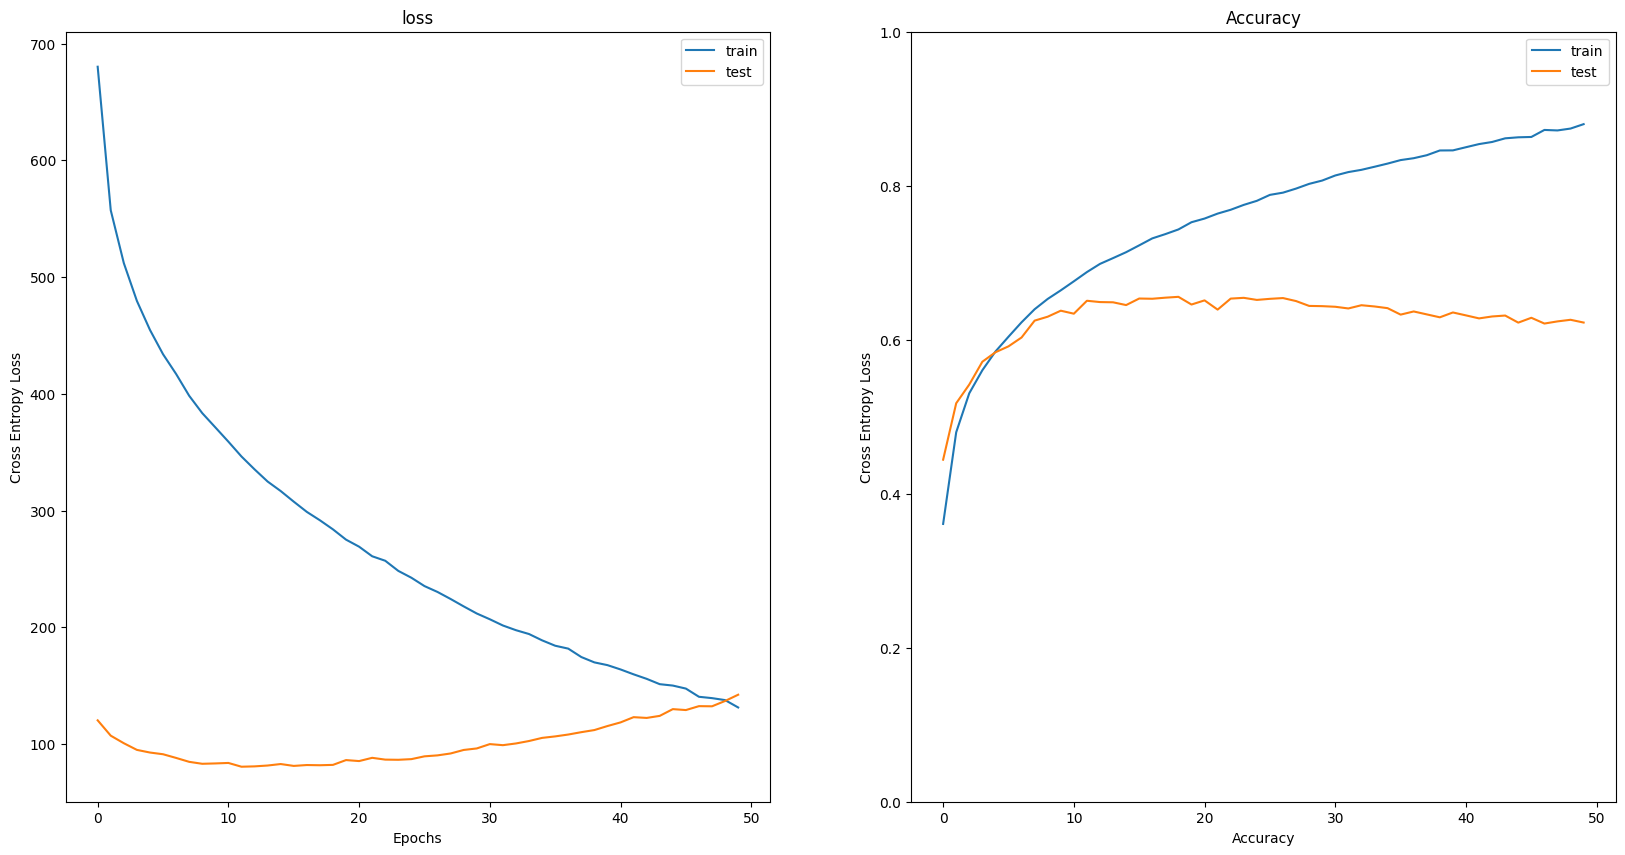

In [325]:
x = list(range(EPOCH_num))
y1 = train_loss_list
y2 = test_loss_list

train_acc_list_not_tensor = []
for t in train_acc_list:
  train_acc_list_not_tensor.append(t.cpu().numpy().copy())
test_acc_list_not_tensor = []
for t in test_acc_list:
  test_acc_list_not_tensor.append(t.cpu().numpy().copy())

y3 = [x/len(trainset) for x in train_acc_list_not_tensor]
y4 = [x/len(testset) for x in test_acc_list_not_tensor]

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1, 2, 1)
ax.set_title("loss")
ax.set_xlabel('Epochs')
ax.set_ylabel('Cross Entropy Loss')
ax.plot(x, y1,label="train")
ax.plot(x, y2,label="test")
ax.legend()
ax = fig.add_subplot(1, 2, 2)
plt.ylim([0,1])
ax.set_title("Accuracy")
ax.set_xlabel('Accuracy')
ax.set_ylabel('Cross Entropy Loss')
#print(x)
#print(y3)
#print(y4)
ax.plot(x, y3,label="train")
ax.plot(x, y4,label="test")
ax.legend()
plt.show()